# Configuración entorno de ejecución

In [50]:
#@title Carga de librerias

#Text
from transformers.models.bert import BertTokenizer, BertModel, BertConfig

#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim

from collections import Counter
import argparse
import functools
from torch.utils.data import DataLoader

import json
import numpy as np



import argparse
import numpy as np
from collections import Counter
from tqdm import tqdm
import shutil
from sklearn.metrics import f1_score
import json
import os
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

import sys
if os.path.abspath("../src") not in sys.path:
    sys.path.append(os.path.abspath("../src"))

from config import *

# 2. Dataset

In [51]:
data = pd.read_csv(TRAIN_FILE)
data = data[["Title", "Review", "Town"]]
data["text"] = data["Title"] + " " + data["Review"]
data = data[["text", "Town"]]

## 2.2 Validación de los datos

In [52]:
data.sample(10)

,text,Town
29652,"Visita obligada en Valladolid Es la Iglesia principal en Valladolid y es donde te dejan los autobuses turísticos, tienen una arquitectura colonial y hay un parque pintoresco enfrente.",Valladolid
49357,"Hotel Mi Casita Excelente ubicación, , hermosa vista, las habitaciones sencillas y limpias. Ofrecen desayuno continental, el personal muy amable. Si llegas por coche, cuentan con estacionamiento a tres cuadras y el costo es de $80.00 pesos diarios. Volvería encantada.",Taxco
155965,"Para mezcales Estando el Mezcal tan de moda es fácil encontrar muchos lugares donde lo vendan, pero encontrar la variedad y calidad qué hay aquí no es fácil ! Muchas opciones y variedades además de meseros conocedores de todas y cada una de las marcas que ofrecen....Más",Cholula
7245,Increíble la ubicación Nos encanta Valle de Bravo y ahora es muy placentero llegar a su hotel y disfrutar de esas instalaciones tan increíbles y saber que tienes la tranquilidad de que descansaras y que te atenderán mejor que estar en casa,Valle_de_Bravo
110039,"Explorar por su cuenta Nuestro hotel estaba en el extremo norte de la ciudad, a 15 minutos, a un corto paseo en bicicleta a las ruinas. No ir a una excursión. Las ruinas tienen letreros en inglés, explicando los edificios y la cultura de la zona. Pasamos 2 horas allí, disfrutar de las ruinas, la pequeña playa, y observación de aves. Impresionante belleza natural. Los mayas que he apreciado la belleza de su tierra.",Tulum
21556,Un excelente paseo por las ruinas de Tulum Un muy buen recorrido por la Zona sintiendo la magia del lugar unas ruinas Mayas con gran conservación y hacer un viaje al pasado de los habitantes de la Zona con esa belleza que lo caracteriza el lugar perfecto para pasar un rico día y bañase en esas aguas ancestrales al pie de la Gran Ciudad Maya,Tulum
113750,Buen hotel La comida y las instalaciones están muy cómodas. Solo mejorar las condiciones del aire acondicionado. Los jardines están muy bonitos. Volvería a regresar sin pensarlo dos veces. La atención es excelente,Palenque
203280,Ruinas mayas y una gran cascada en una pero demasiados vendedores Las hermosas ruinas mayas en un parque natural donde se puede subir las piramids y tienen un gran descenso paseo por un río natural.El lugar sería aún más bonita si hay menos puestos artesanos y vendedores que realmente nos arruinó la experiencia y son un dolor. Uno me encantaría disfrutar de este lugar de paz que sería posible incluso con grandes multitudes si no fuera por los vendedores.,Palenque
151009,"Aparte del centro turístico Este restaurante está ubicado fuera de la carretera turística principal, y un poco detrás, pero es mucho mejor que los restaurantes demasiado ""guiris"" La comida es deliciosa y bien presentada, servicio atento y cordial. Los platos llegue rápidamente y están bien presentadas. Un lugar que...se merece algo mejor que el 22Â° lugar. Muy acogedor ambiente agradable casi como una terraza en la calle. Fuimos dos veces durante nuestra estancia y el dueño siempre estaba presente para asegurar la calidad del servicio. Bravo!Más",Isla_Mujeres
44627,"Increíble curry verde Llegamos sin reservación en una noche muy concurrida en diciembre. amablemente nos pusieron en el bar con vista a la cocina. trabajaron con el fin especial de mi hija, y para mí uno de los mejores curry verde que he comido en mi vida. Bonitas...gran camarones y calamares trozos, hermosos verduras frescas y caldo fantástico perfectamente preparada con arroz en un lado. Los chefs hizo la elaboración de parece fácil, pero para aquellos de nosotros que han intentado, su habilidad fue en la exposición y el sabor era genial. Nos hubiera gustado haber descubierto Bangcook antes pero, por desgracia, nos encontramos en nuestra última noche en la ciudad.Más",San_Cristobal_de_las_Casas


In [53]:
data.dtypes

text    object
Town    object
dtype: object

In [54]:
data["type"]=data.Town.apply(lambda e: isinstance(e, str))

In [55]:
data[data.type==False]

,text,Town,type


In [56]:
data.dropna(inplace=True)

In [57]:
print(f"Tamaño del dataset: {len(data)}")

Tamaño del dataset: 208049


In [58]:
print(f"Tamaño del dataset muestra: {len(data)}")

Tamaño del dataset muestra: 208049


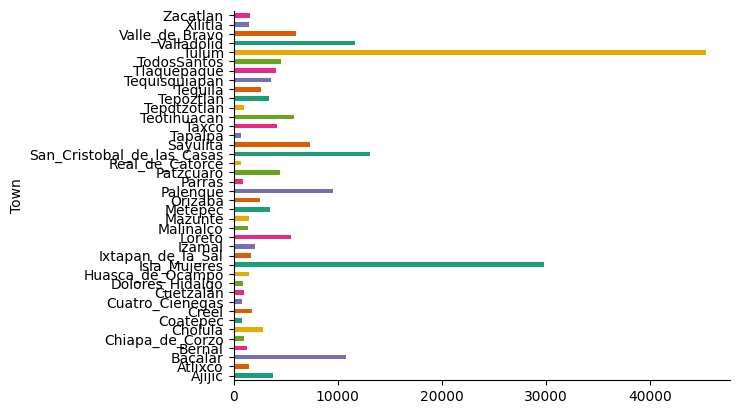

In [59]:
# @title Clases

from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Town').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
train, test = train_test_split(data, test_size=0.10, random_state=42)

In [62]:
train, val = train_test_split(train, test_size=0.11, random_state=42)

In [63]:
print(f"Tamaño train dataset: {len(train)}")
print(f"Tamaño test dataset: {len(test)}")
print(f"Tamaño val dataset: {len(val)}")

Tamaño train dataset: 166647
Tamaño test dataset: 20805
Tamaño val dataset: 20597


In [64]:
#save dataset
train.to_csv("train.csv",index=False)
test.to_csv("test.csv",index=False)
val.to_csv("val.csv",index=False)

## 2.3 Procesamiento del dataset

In [65]:
class EcommerceDataset(Dataset):
    def __init__(self, data_path, args):
        """
          data_path: ruta del archivo .csv que contiene labels y product_descriptions
          args: hiperparámetros

        """
        self.data = pd.read_csv(data_path)
        self.tokenizer = BertTokenizer.from_pretrained(args.bert_model) #función preprocesa y divide el texto en tokens
        self.args = args
        self.n_classes = len(args.labels)
        self.max_seq_len = args.max_seq_len #512


    def __len__(self):
        return len(self.data)

    def load_text(self, index, key=""):
      inputs=self.tokenizer(self.data.loc[index][key], return_tensors="pt", padding='max_length',truncation=True)
      sentence=inputs.input_ids[0]
      segment=inputs.token_type_ids[0]
      attmask=inputs.attention_mask[0]

      return sentence, segment, attmask



    def __getitem__(self, index):
      sentence, segment, attmask = None, None, None

      # Load text
      sentence, segment, attmask= self.load_text(index,"text")


      # Process labels
      label = torch.zeros(self.n_classes)
      tgt = self.data.loc[index]["Town"]
      label[self.args.labels.index(tgt)] = 1


      return sentence, segment, attmask, label

In [66]:
def get_labels_and_frequencies(path):
    label_freqs = Counter()
    data_labels = list(pd.read_csv(path).Town)
    label_freqs.update(data_labels)

    return list(label_freqs.keys()), label_freqs

In [67]:
def collate_fn(batch, args):

    text_tensor, segment_tensor, attmask_tensor,= None, None, None

    text_tensor=torch.stack([row[0] for row in batch])
    segment_tensor=torch.stack([row[1] for row in batch])
    attmask_tensor=torch.stack([row[2] for row in batch])

    tgt_tensor = torch.stack([row[3] for row in batch])

    return text_tensor, segment_tensor, attmask_tensor, tgt_tensor

In [68]:
def get_data_loaders(args):

  args.labels, args.label_freqs = get_labels_and_frequencies(
            os.path.join(args.data_path, args.task, "train.csv")
        )

  args.n_classes = len(args.labels)

  train = EcommerceDataset(
            os.path.join(args.data_path, "train.csv"),
            args,
        )

  args.train_data_len = len(train)

  dev = EcommerceDataset(
        os.path.join(args.data_path, "val.csv"),
        args,
    )

  test_set = EcommerceDataset(
        os.path.join(args.data_path, "test.csv"),
        args
    )

  collate = functools.partial(collate_fn, args=args)

  train_loader = DataLoader(
        train,
        batch_size=args.batch_sz,
        shuffle=True,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  val_loader = DataLoader(
        dev,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )
  test_loader = DataLoader(
        test_set,
        batch_size=args.batch_sz,
        shuffle=False,
        num_workers=args.n_workers,
        collate_fn=collate,
    )

  return train_loader, val_loader, test_loader

# 3. Configuracion del entrenamiento general

In [69]:
import random
#Para reproducción de resultados
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [70]:
def model_forward(i_epoch, model, args, criterion, batch):

    txt, segment, attmask, tgt= batch
    txt, attmask, segment = txt.cuda(), attmask.cuda(), segment.cuda()
    out = model(txt, attmask, segment) #out for supervised loss

    tgt = tgt.cuda()
    final_loss = criterion(out, tgt)

    return final_loss, out, tgt

In [71]:
from sklearn.metrics import f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report

In [72]:
def model_eval(i_epoch, data, model, args, criterion):
    with torch.no_grad():
        losses, preds, tgts = [], [], []
        probs= []
        for batch in data:
            loss, out, tgt = model_forward(i_epoch, model, args, criterion, batch)
            losses.append(loss.item())

            prob = torch.nn.functional.softmax(out,dim=-1).cpu().detach().numpy()
            index_max = prob.argmax(axis=-1)
            pred = np.zeros(prob.shape)
            for i in range(len(index_max)):
                pred[i][index_max[i]]=1


            preds.append(pred)
            probs.append(prob)
            tgt = tgt.cpu().detach().numpy()
            tgts.append(tgt)

    tgts = np.vstack(tgts)
    preds = np.vstack(preds)
    probs = np.vstack(probs)
    report = classification_report(tgts, preds, output_dict=True)
    #print(report)
    metrics = {"loss": np.mean(losses)}
    metrics = {"weighted avg": report['weighted avg']}

    return metrics

In [73]:
def save_checkpoint(state, is_best, checkpoint_path, filename="checkpoint.pt"):
    filename = os.path.join(checkpoint_path, filename)
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, "model_best.pt"))

In [74]:
def train(args,model):
    args.savedir = os.path.join(args.savedir, args.name)
    os.makedirs(args.savedir, exist_ok=True)

    model.cuda()

    torch.save(args, os.path.join(args.savedir, "args.pt"))

    start_epoch, global_step, n_no_improve, best_metric = 0, 0, 0, -np.inf

    #Cargar estado del modelo si ya existía previamente
    if os.path.exists(os.path.join(args.savedir, "checkpoint.pt")):
        checkpoint = torch.load(os.path.join(args.savedir, "checkpoint.pt"))
        start_epoch = checkpoint["epoch"]
        n_no_improve = checkpoint["n_no_improve"]
        best_metric = checkpoint["best_metric"]
        model.load_state_dict(checkpoint["state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scheduler.load_state_dict(checkpoint["scheduler"])

    len_train =len(train_loader)
    for i_epoch in range(start_epoch, args.max_epochs):
        train_losses = []
        model.train()
        optimizer.zero_grad()

        for batch in tqdm(train_loader, total=len_train):
            loss, _, _ = model_forward(i_epoch, model, args, criterion, batch)
            if args.gradient_accumulation_steps > 1:
                loss = loss / args.gradient_accumulation_steps

            train_losses.append(loss.item())
            loss.backward()
            global_step += 1
            if global_step % args.gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        model.eval() #desactiva el dropout
        metrics= model_eval(i_epoch, val_loader, model, args, criterion)
        print("Train Loss: {:.4f}".format(np.mean(train_losses)))
        print("Val:", metrics)

        tuning_metric = (
            metrics['weighted avg']['f1-score']
        )

        scheduler.step(tuning_metric)
        is_improvement = tuning_metric > best_metric
        if is_improvement:
            best_metric = tuning_metric
            n_no_improve = 0
        else:
            n_no_improve += 1

        #Guardar estado actual del modelo
        save_checkpoint(
            {
                "epoch": i_epoch + 1,
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "n_no_improve": n_no_improve,
                "best_metric": best_metric,
            },
            is_improvement,
            args.savedir,
        )

        if n_no_improve >= args.patience:
              print("No improvement. Breaking out of loop.")
              break

    load_checkpoint(model, os.path.join(args.savedir, "model_best.pt"))
    model.eval()
    test_metrics= model_eval(
        np.inf, test_loader, model, args, criterion, store_preds=True
    )
    print(f"Test:", test_metrics)

In [75]:
def load_checkpoint(model, path):
    best_checkpoint = torch.load(path)
    model.load_state_dict(best_checkpoint["state_dict"])

# 4. BERT

## 4.1 Clasificador

In [76]:
class BertClf(nn.Module):
    def __init__(self, args):
        super(BertClf, self).__init__()
        self.args = args
        self.bert = BertModel.from_pretrained(args.bert_model) #Encoder
        self.dropout= nn.Dropout(args.dropout)
        self.clf = nn.Linear(args.hidden_sz, args.n_classes) #Cabezal de clasificación

    def forward(self, txt, mask, segment):
        _, x = self.bert(
            input_ids=txt,
            token_type_ids=segment,
            attention_mask=mask,
            return_dict=False,
        )
        x= self.dropout(x)
        return self.clf(x)

## 4.2 Entrenamiento

### 4.1.1 BERT base

In [77]:
set_seed(1)
args = argparse.Namespace(
        bert_model="bert-base-uncased",
        model="bert",
        batch_sz=8,
        max_seq_len=512,
        n_workers=2,
        dropout=0.1,
        hidden_sz=768,
        gradient_accumulation_steps=16,
        max_epochs=10,
        patience=2,
        lr=1e-4,
        lr_patience=2,
        lr_factor = 0.5,
        warmup=0.1,
        data_path="",
        task="",
        savedir="",
        name="bert_base_1",
    )

In [78]:
train_loader, val_loader, test_loader = get_data_loaders(args)

In [79]:
#Modelo
bert_base = BertClf(args)

In [80]:
bert_base.bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [81]:
#Criterion
freqs = [args.label_freqs[l] for l in args.labels]
label_weights = (torch.FloatTensor(freqs) / args.train_data_len) ** -1
criterion = nn.BCEWithLogitsLoss(pos_weight=label_weights.cuda())
#optimizer
optimizer = optim.AdamW(bert_base.parameters(), lr=args.lr)
#scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, "max", patience=args.lr_patience, factor=args.lr_factor
    )

torch.cuda.is_available()

True

In [82]:
train(args,bert_base)

  0%|          | 103/20831 [00:42<2:21:33,  2.44it/s]


KeyboardInterrupt: 

In [ ]:
def model_predict(model,text,args):
  with torch.no_grad():
    tokenizer = BertTokenizer.from_pretrained(args.bert_model)
    inputs=tokenizer(text, return_tensors="pt", padding='max_length',truncation=True)
    txt=inputs.input_ids
    segment=inputs.token_type_ids
    attmask=inputs.attention_mask
    txt, attmask, segment = txt.cuda(), attmask.cuda(), segment.cuda()

    out = bert_base(txt, attmask, segment)
    prob = torch.nn.functional.softmax(out[0],dim=0)
    index_max = prob.argmax(axis=0)
    pred= args.labels[index_max]

  return pred, prob

In [ ]:
text="GoPro Fetch Dog Harness Mount for Camera Style name:Fetch (Dog Harness) GoPro harnais pour chiens - fetch pour HERO 1, 2, 3, 3+, 4."
model_predict(bert_base,text,args)

('Electronics',
 tensor([3.1366e-05, 7.7352e-05, 1.2388e-05, 9.9988e-01], device='cuda:0'))

In [ ]:
text="Speech and Language Processing Pasta dura – Illustrated, 1 abril 2008  Edición Inglés  por Daniel Jurafsky (Autor), James Martin (Autor) For undergraduate or advanced undergraduate courses in Classical Natural Language Processing, Statistical Natural Language Processing, Speech Recognition, Computational Linguistics, and Human Language Processing. An explosion of Web-based language techniques, merging of distinct fields, availability of phone-based dialogue systems, and much more make this an exciting time in speech and language processing. The first of its kind to thoroughly cover language technology - at all levels and with all modern technologies - this text takes an empirical approach to the subject, based on applying statistical and other machine-learning algorithms to large corporations. The authors cover areas that traditionally are taught in different courses, to describe a unified vision of speech and language processing. Emphasis is on practical applications and scientific evaluation. An accompanying Website contains teaching materials for instructors, with pointers to language processing resources on the Web. The Second Edition offers a significant amount of new and extended material"
model_predict(bert_base,text,args)

('Books',
 tensor([9.9993e-01, 1.1027e-05, 1.4836e-05, 4.6559e-05], device='cuda:0'))

In [ ]:
text="U.S. Polo Assn. Men's Cotton Casual Jacket U.S. Polo Assn. Men Dark Blue Plain / Solid Sleeveless V-neck Regular Fit Casual XXX-Large Waistcoats"
model_predict(bert_base,text,args)

('Clothing & Accessories',
 tensor([1.2601e-05, 7.7216e-05, 9.9989e-01, 1.6155e-05], device='cuda:0'))

In [ ]:
text = "BESTONZON 2pcs Wooden Crepe Spreader Pancake Maker Batter Dough Spreader DIY Kitchen Tool Size:2 pcs DescriptionMade of high quality wood, it is safe, non-toxic and durable. Pour your batter into the pan and use the spreader in a circular motion to spread the batter. You can make delicious crepes easily with the right tool"
model_predict(bert_base,text,args)

('Household',
 tensor([8.7531e-06, 9.9994e-01, 1.0355e-05, 4.5056e-05], device='cuda:0'))

In [ ]:
bert_base.cuda()
text="iphone 12 4gb ram"
model_predict(bert_base,text,args)

('Electronics',
 tensor([5.5867e-05, 5.4739e-05, 8.2725e-06, 9.9988e-01], device='cuda:0'))

In [ ]:
bert_base.cuda()
text="IPHONE 12 4GB RAM"
model_predict(bert_base,text,args)

('Electronics',
 tensor([5.5867e-05, 5.4739e-05, 8.2725e-06, 9.9988e-01], device='cuda:0'))